# `Setup`

In [2]:
!pip install pandas
!pip install matplotlib
!pip install seaborn
!pip install torchvision
!pip install torch

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import time
import copy
import datetime as dt
from math import ceil
try:
    # Mounting Colab Drive if possible
    from google.colab import drive
    drive.mount('/content/drive')

    # Cloning repo for colab
    if 'aml_itu' in os.getcwd():
        %cd aml_itu/
        !git pull https://github.com/RasKrebs/aml_itu
    else:
        !git clone https://github.com/RasKrebs/aml_itu
        %cd aml_itu/
    os.environ["COLAB"] = "True"

except:
    # Changing directory into aml_itu
    if os.getcwd().split('/')[-1] != 'aml_itu': os.chdir(os.path.abspath('.').split('aml_itu/')[0]+'aml_itu')
    !git pull origin main --ff-only
    os.environ["COLAB"] = "False"

# Utils Import
from utils.helpers import *
from utils.StatefarmPytorchDataset import StateFarmDataset


# Torch
import torch
from torch.autograd import Variable
from torch import nn
import torchvision
import torchvision.transforms as T
from torchvision.transforms import v2
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from utils.models.EfficientNet import EfficientNet
import math


# Install torchinfo, import if it's available
try:
  import torchinfo
except:
  !pip install torchinfo
  import torchinfo

from torchinfo import summary


# Printing current working directory
print(os.getcwd())

# Setting up device
if torch.cuda.is_available():
    device = torch.device("cuda")
    print (f"GPU is available")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
    print('MPS device found.')
else:
    print ("No GPU available, using CPU instead")

From https://github.com/RasKrebs/aml_itu
 * branch            main       -> FETCH_HEAD
Already up to date.
/home/ucloud/aml_itu
GPU is available


In [2]:
# Setting seed
def set_seed (seed = 42):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.mps.manual_seed(seed)
    
set_seed(42)

### `Config`

In [3]:
# Loading the config file (if content is in workin directory must mean colab is being used)
config = load_config(eval(os.environ["COLAB"]))


# Training Images
train_img = config['dataset']['images']['train']

# Outputting config
config

{'dataset': {'name': 'state-farm-distracted-driver-detection',
  'colab_path': '/content/drive/MyDrive/aml-distracted-drivers-project',
  'data': '../state-farm-distracted-driver-detection/driver_imgs_list.csv',
  'images': {'train': '../state-farm-distracted-driver-detection/imgs/train',
   'test': '../state-farm-distracted-driver-detection/imgs/test'},
  'class_mapping': {'c0': 'safe driving',
   'c1': 'texting - right',
   'c2': 'talking on the phone - right',
   'c3': 'texting - left',
   'c4': 'talking on the phone - left',
   'c5': 'operating the radio',
   'c6': 'drinking',
   'c7': 'reaching behind',
   'c8': 'hair and makeup',
   'c9': 'talking to passenger'}},
 'outputs': {'path': './outputs'},
 'modeling_params': {'batch_size': 32, 'epochs': 100}}

## `EfficientNet`

In [4]:
# IMG Transformations
# IMG Transformations
augmentations = {
    'train': v2.Compose([
    v2.RandomRotation(degrees=30),
    v2.RandomResizedCrop(224, antialias=True, scale=(0.9, 1)),
    v2.RandomHorizontalFlip(p=0.5),
    v2.ToDtype(torch.float32, scale=True)]),
    'val+test': v2.Compose([
    T.Resize(224, antialias=True),
    v2.ToDtype(torch.float32, scale=True)])}

# Target Transformations (Removing the c from the target)
target_transform = T.Lambda(lambda y: torch.tensor(int(y.replace('c', ''))))

In [5]:
# Normal Dataset
# Creating the dataset
train_data = StateFarmDataset(config, 
                              transform=augmentations['train'], 
                              split='none', 
                              target_transform=target_transform)

print(f'Lenght of train data: {len(train_data)}')

test_data = StateFarmDataset(config, 
                            split='test', 
                            transform=augmentations['val+test'], 
                            target_transform=target_transform)

print(f'Lenght of val data: {len(test_data)}')

Lenght of train data: 17754
Lenght of val data: 4670


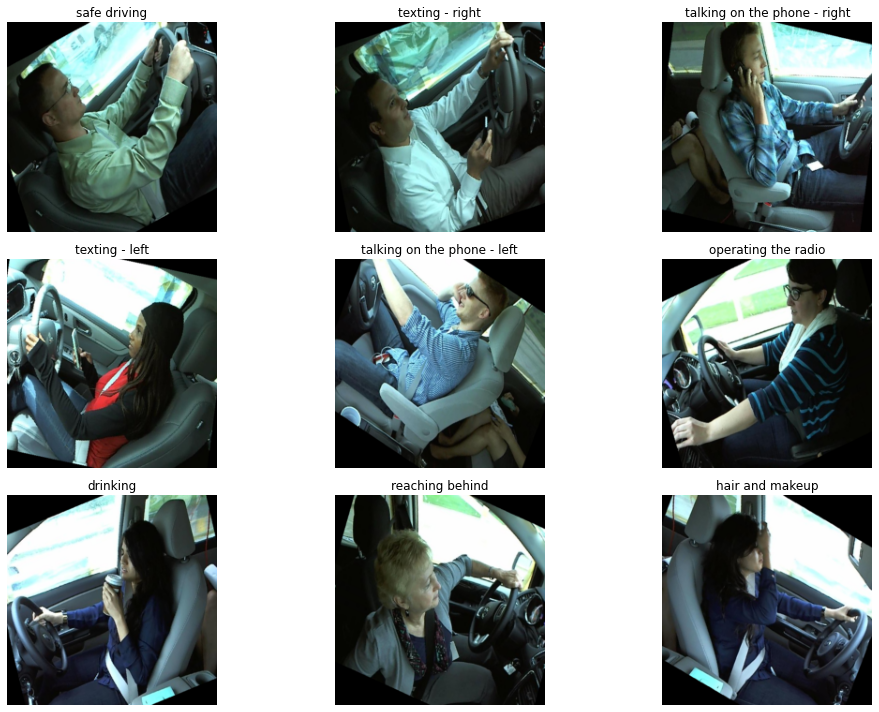

In [6]:
# Displaying training data including transformations
train_data.display_classes(id_to_class=True)

#### `Model`

In [17]:
batch_size = config['modeling_params']['batch_size']
epochs = 17 # Average early stopping from CV
seed = 42

train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

In [18]:
# Model summary
x, y = next(iter(train_dataloader))
model = EfficientNet()
summary(model, input_size=x.shape)

Layer (type:depth-idx)                             Output Shape              Param #
EfficientNet                                       [32, 10]                  --
├─Sequential: 1-1                                  [32, 1280, 7, 7]          --
│    └─ConvBnAct: 2-1                              [32, 32, 112, 112]        --
│    │    └─Conv2d: 3-1                            [32, 32, 112, 112]        864
│    │    └─BatchNorm2d: 3-2                       [32, 32, 112, 112]        64
│    │    └─SiLU: 3-3                              [32, 32, 112, 112]        --
│    └─MBConvN: 2-2                                [32, 16, 112, 112]        --
│    │    └─Identity: 3-4                          [32, 32, 112, 112]        --
│    │    └─ConvBnAct: 3-5                         [32, 32, 112, 112]        352
│    │    └─SqueezeExcitation: 3-6                 [32, 32, 112, 112]        552
│    │    └─ConvBnAct: 3-7                         [32, 16, 112, 112]        544
│    └─MBConvN: 2-3            

#### `Training Methods`

In [10]:
def visualize_training(history, num_epochs=50):
    
    # Generate Figure
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))
    
    # Loss Plots
    sns.lineplot(y=history['train_loss'], x=list(range(len(history['train_loss']))), ax=axs[0], label='Train Loss')
    sns.lineplot(y=history['val_loss'], x=list(range(len(history['val_loss']))), ax=axs[0], label='Validation Loss')
    axs[0].set_ylabel('Cross Entropy Loss')
    axs[0].set_xlabel('Epochs')
    axs[0].set_xlim(0, num_epochs)

    # Accuracy Plots
    sns.lineplot(y=history['train_acc'], x=list(range(len(history['train_acc']))), ax=axs[1], label='Train Accuracy')
    sns.lineplot(y=history['val_acc'], x=list(range(len(history['val_acc']))), ax=axs[1], label='Validation Accuracy')
    axs[1].set_ylabel('Accuracy')
    axs[1].set_xlabel('Epochs')
    axs[1].set_xlim(0, num_epochs)
    
    # Show plot
    plt.show()

In [11]:
def train_step(model, dataloader, loss_fn,optimizer, device):
    """Train step for a single epoch. Taken from PyTorch 'Training with PyTorch'"""
    
    # Losses and accuracies
    train_loss, train_acc = 0, 0

    for i, data in enumerate(dataloader):
        
        # Extracting data and labels + moving to device
        imgs, labels = data
        imgs, labels = imgs.to(device), labels.to(device)
        
        # Zero-ing gradients for every new batch
        optimizer.zero_grad()

        # Forward pass
        prediction = model(imgs)
        
        # Computing Loss and Gradient
        loss = loss_fn(prediction, labels)
        loss.backward()

        optimizer.step()

        # Update train loss and accuracy
        train_loss += loss.item()
        train_acc += (prediction.argmax(1) == labels).type(torch.float).mean().item()
    # Return train loss and accuracy
    return train_loss / len(dataloader), train_acc / len(dataloader)


In [12]:
def validation(model, dataloader, loss_fn, device):
    """Validation loop"""
    # Setup validation loss and accuracy
    val_loss, val_acc = 0, 0

    # Disable gradient calculations
    with torch.no_grad():
        for i, data in enumerate(dataloader):   
            # Extract imgs and labels and sent to device
            imgs, labels = data
            imgs, labels  = imgs.to(device), labels.to(device)

            # Forward pass and update validation loss
            prediction = model(imgs)
            loss = loss_fn(prediction, labels)
            val_loss += loss.item()

            # Update validation accuracy
            val_acc += (prediction.argmax(1) == labels).type(torch.float).mean().item()
    # Return validation loss and accuracy
    return val_loss / len(dataloader), val_acc / len(dataloader)

In [13]:
def save_model(model, model_name, epoch):
    """Function for saving model"""
    # Model name, with path
    timestamp = dt.datetime.now().strftime('%Y%m%d_%H%M%S')
    file = f'{model_name}_{timestamp}_epoch_{epoch+1}'
    name = os.path.join(config['outputs']['path'], model_name, file)
    
    # Make directory if not exists
    if not os.path.exists(os.path.join(os.path.join(config['outputs']['path'], model_name))):
        os.makedirs(os.path.join(os.path.join(config['outputs']['path'], model_name)))
    
    # Save model
    torch.save(model.state_dict(), f'{name}.pt')

In [14]:
class EarlyStopper:
    """Early Stopping Class. Copied from https://stackoverflow.com/questions/71998978/early-stopping-in-pytorch"""
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = float('inf')

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            if self.counter != 0:
                print('Early Stopping Counter Reset')
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            print(f'Early Stopping Counter {self.counter} of {self.patience}')
            if self.counter >= self.patience:
                return True
        return False

In [19]:
def train(model, train_dataloader, optimizer, loss_fn, epochs, device):
    """Model training method"""
    # History
    history = dict(train_loss=[],
                   train_acc=[])

    # Save start of training
    total_training_start = time.time()
    # Loop through epochs
    for epoch in range(epochs):
        print(f'\nEpoch {epoch+1} of {epochs} started...')
        
        # Get start training step time
        start_train = time.time()
        
        # Set model to train mode and do pass over data - plus save start of training step
        model.train(True)
        train_loss, train_acc = train_step(model, train_dataloader, loss_fn, optimizer, device)

        # Set model to eval and do pass over validation data + time for start of validation step
        # model.eval()
        # val_loss, val_acc = validation(model, validation_dataloader, loss_fn, device)
        
        # Calculate total time spent
        end_train = time.time()
        total_m, total_s = divmod(end_train - start_train, 60)
        
        # lr Scheduler step
        # if scheduler != None:
        #     scheduler.step(val_loss)
        
        print(f"Epoch {epoch+1} of {epochs} ({round(total_m)}:{round(total_s)}) - Train loss: {train_loss:.5f} - Train acc: {train_acc:.5f}")
        
        
        # Save model if val loss is lower than previous lowest
        # if val_loss < min(history['val_loss'], default=1e10):
        #     print(f"Saving model with new best val_loss: {val_loss:.5f}")
        #     
        #     # Save model
        #     save_model(model, model_name, epoch)
        
        # Save train and val loss/acc
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        # history['val_loss'].append(val_loss)
        # history['val_acc'].append(val_acc)

        # Visualize every 5th epoch
        # if (epoch + 1) % 5 == 0: 
        #     visualize_training(history, epochs)
            
        # if early_stopping.early_stop(val_loss):             
        #     print(f"Epoch {epoch+1} of {epochs} - Early stopping")
        #     print('Saving final model, with loss: ', val_loss)
        #     save_model(model, model_name, epoch)
        #     visualize_training(history, epoch+1)
        #     break
    total_training_end = time.time()
    minutes, seconds = divmod(total_training_end-total_training_start, 60)
    
    print(f'Total training time: {round(minutes)}:{round(seconds)}')
    return history

In [20]:
# Set random seeds
torch.manual_seed(42)

# Initialize Efficientnet model
MODEL_NAME = 'EfficientNet_b0_Final'
model = EfficientNet()
model = model.to(device) # Load model to device.

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)

# results
results = train(model=model,
                train_dataloader=train_dataloader,
                optimizer=optimizer,
                loss_fn=loss_fn,
                epochs=epochs,
                device=device)


Epoch 1 of 17 started...
Epoch 1 of 17 (6:4) - Train loss: 2.20161 - Train acc: 0.15914

Epoch 2 of 17 started...
Epoch 2 of 17 (5:55) - Train loss: 1.40603 - Train acc: 0.46444

Epoch 3 of 17 started...
Epoch 3 of 17 (5:42) - Train loss: 0.68271 - Train acc: 0.76791

Epoch 4 of 17 started...
Epoch 4 of 17 (5:44) - Train loss: 0.43709 - Train acc: 0.85845

Epoch 5 of 17 started...
Epoch 5 of 17 (5:54) - Train loss: 0.33678 - Train acc: 0.89219

Epoch 6 of 17 started...
Epoch 6 of 17 (5:55) - Train loss: 0.27554 - Train acc: 0.91090

Epoch 7 of 17 started...
Epoch 7 of 17 (5:59) - Train loss: 0.22947 - Train acc: 0.92840

Epoch 8 of 17 started...
Epoch 8 of 17 (6:2) - Train loss: 0.20598 - Train acc: 0.93635

Epoch 9 of 17 started...
Epoch 9 of 17 (6:1) - Train loss: 0.17346 - Train acc: 0.94647

Epoch 10 of 17 started...
Epoch 10 of 17 (6:4) - Train loss: 0.16995 - Train acc: 0.94672

Epoch 11 of 17 started...
Epoch 11 of 17 (6:1) - Train loss: 0.14701 - Train acc: 0.95285

Epoch 12 o

In [30]:
# Saving model
out = '/home/ucloud/aml_itu/outputs/EfficientNet/' + 'EfficientNet_final.pt'
torch.save(model.state_dict(), out)

### Testing on Test Images

In [41]:
def test(model, dataloader, device):
    """Test loop"""
    # Setup test accuracy
    test_acc = 0
    model.eval()
    images = []
    classes = []
    predictions = []
    predictions_argmax = []
    
    # Disable gradient calculations
    with torch.no_grad():
        for i, data in enumerate(dataloader):   
            # Extract imgs and labels and sent to device
            imgs, labels = data
            images.append(imgs), classes.append(labels)
            
            imgs, labels  = imgs.to(device), labels.to(device)

            # Forward pass
            prediction = model(imgs)
            predictions.append(prediction)
            predictions_argmax.append(prediction.argmax(1))

            # Update test accuracy
            test_acc += (prediction.argmax(1) == labels).type(torch.float).mean().item()
    # Return test accuracy
    print(f'Test Accuracy {test_acc / len(dataloader)}')
    return images, classes, predictions, predictions_argmax

In [42]:
test_predictions = test(model=model,
                        dataloader=test_dataloader,
                        device=device)

Test Accuracy 0.4818207764462249


In [ ]:
best_model = EfficientNet(width_mult, depth_mult, dropout_rate, num_classes = 10).to(device)
best_model.load_state_dict(torch.load('/Users/rasmuskrebs/Documents/School/semester_3/advanced_ml/aml_itu/outputs/EfficientNet_b0_AdamW/EfficientNet_b0_AdamW_20231204_093524_epoch_5.pt'))

In [ ]:
best_predictions = test(model=best_model,
                        dataloader=test_dataloader,
                        device=device)